In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import math
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

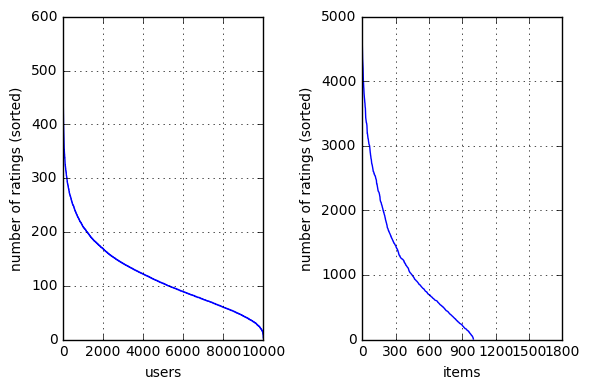

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
from plots import plot_train_test_data
from helpers import split_data

valid_ratings, train_unfiltered, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)


Total number of nonzero elements in original data:1176873
Total number of nonzero elements in train data:1058916
Total number of nonzero elements in test data:117957


In [5]:
from outliers_filtering import *
#d = disagreements(train_unfiltered)
#plot_disagreements(d)
#train = filter_outliers(train_unfiltered,d)
#nfiltered = train_unfiltered.nnz - train.nnz
#print("number of filtered ratings : {}".format(nfiltered))
train = train_unfiltered

In [6]:
from outliers_filtering import threshold_tests
threshold_tests(d, train_unfiltered, valid_ratings, test)

NameError: name 'd' is not defined

## Implementing Baselines 

### Use the global mean to do the prediction

In [30]:
from helpers import calculate_mse
from baselines import baseline_global_mean, compute_rmse

train_mean, test_mean = baseline_global_mean(train, test)
pred = np.ones(train.shape) * train_mean
test_pred = np.ones(test.shape) * test_mean


rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

1.11567752157
1.11905221478


### Use the user means as the prediction

In [ ]:
from baselines import baseline_user_mean

train_means, test_means = baseline_user_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[1]):
    pred[:,col] *= train_means_list[0][col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[1]):
    test_pred[:,col] *= test_means_list[0][col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Use the item means as the prediction

In [ ]:
from baselines import baseline_item_mean
from helpers import exportSubmission

train_means, test_means = baseline_item_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[0]):
    pred[col,:] *= train_means_list[col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[0]):
    test_pred[col,:] *= test_means_list[col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

Compute the cost by the method of matrix factorization.


iter: k = 30, RMSE on training set: 2.8472014949081195.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.7860476640497496.
iter: 10, RMSE on training set: 1.072267813959614.
iter: 20, RMSE on training set: 1.029250607266135.
iter: 30, RMSE on training set: 1.010452695060202.
iter: 40, RMSE on training set: 0.9985192477513356.
iter: 50, RMSE on training set: 0.9898284969805184.
iter: 60, RMSE on training set: 0.98306042559152.
iter: 70, RMSE on training set: 0.977520361640855.
iter: 80, RMSE on training set: 0.9727744711594994.
iter: 90, RMSE on training set: 0.968712804164225.
iter: 100, RMSE on training set: 0.965146057324347.
iter: 110, RMSE on training set: 0.9617871970217926.
iter: 120, RMSE on training set: 0.9588946017983973.
iter: k = 30, RMSE on training set: 2.845651893735437.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.7890616400521184.
iter: 10, RMSE on training set: 1.0768092672083396.
iter: 20, RMSE on training s

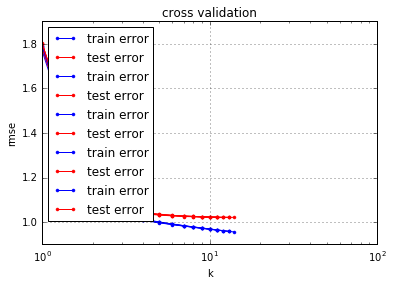

In [65]:
from matrix_factorization import multiple_matrix_factorization_SGD
from helpers import pick_lowest_rmse
# set seed
np.random.seed(988)
results = multiple_matrix_factorization_SGD(train, test, num_epochs=500, ntries=5)
print(results)
rmse, user_features, item_features = pick_lowest_rmse(test, results, test.nonzero())
print(rmse)

In [59]:
from helpers import exportSubmission
pred =  (item_features @ user_features.T)
exportSubmission("data/submission_MF.csv", pred)

number of items: 1000, number of users: 10000


In [ ]:
from matrix_factorization import matrix_factorization_SGD
from helpers import compute_error
errors = []
for i in np.arange(5, 40, 5):
    user_features, item_features = matrix_factorization_SGD(train, test, num_epochs = 1000, num_features = i)
    error = compute_error(test, user_features, item_features, test.nonzero())
    errors.append(error)


In [ ]:
from plots import visualization
visualization(np.arange(5, 40, 5),errors,errors)
print(errors)

### Learn the Matrix Factorization using Alternating Least Squares

In [7]:
def nz_indices_along_axis(M, axis):
    """Takes a matrix M and axis=[0|1], and returns the indices of the non-zero elements along axis.
    If axis=0, returns for each row the indices of non-zero elements in that row. If axis=1, returns
    for each column the indices of non-zero elements in that column."""
    resultLength = M.shape[axis]
    indices = np.empty(resultLength, 'O')
    for k in range(resultLength):
        if axis == 0:
            a = np.nonzero(M[k, :])
        else:
            a = np.nonzero(M[:, k])
        indices[k] = a[0]
    return indices

def update_user_feature(train, W, lZ,
                        nz_user_itemindices):
    """update and return user feature matrix."""
    N = train.shape[1]
    K = W.shape[1]
    Z = np.zeros((N, K))
    for n in range(N):
        # nz_user_itemindices[n] is the set of row indices of X where user n rated an item ;
        # W_On are the rows of W corresponding to those indices
        W_On = W[nz_user_itemindices[n], :]
        X_On = (train[nz_user_itemindices[n], n]).toarray()
        Z[n,:] = np.linalg.solve(W_On.T.dot(W_On) + lZ * np.identity(K), (W_On.T).dot(X_On)).ravel()
    return Z

def update_item_feature(train, Z, lW,
                        nz_item_userindices):
    """update and return item feature matrix."""
    D = train.shape[0]
    K = Z.shape[1]
    W = np.zeros((D, K))
    for d in range(D):
        Z_Od = Z[nz_item_userindices[d], :]
        X_Od = train[d, nz_item_userindices[d]].toarray()
        W[d,:] = np.linalg.solve(Z_Od.T.dot(Z_Od) + lW * np.identity(K), (Z_Od.T).dot(X_Od.T)).ravel()
    return W

In [ ]:
def init_W(W):
    """Initialize the item matrix W by assigning the average
    rating for that movie as the first row, and
    small random numbers for the remaining entries."""
    W[0, :] = np.mean(W[0, :])
    W[1:,:] = np.random.rand()
    return W

def F2(matrix):
    return np.linalg.norm(matrix, 'fro') ** 2

def compute_error(X, W, Z, nz, lW, lZ):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    #print(X.shape, W.shape, Z.shape)
    return 0.5 * (F2(X[nz] - (W.dot(Z.T))[nz]) + lW * F2(W) + lZ * F2(Z)) / nz[0].shape[0]

def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20 # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4 / train.nnz
    iteration = 1
    error_list = [0, 1]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = (np.zeros((train.shape[1], num_features)), np.zeros((train.shape[0], num_features)))

    # start ALS-WR algorithm
    # ***************************************************
    # nnz_items_per_user
    nz_user_itemindices = nz_indices_along_axis(train, 1)
    # nnz_users_per_item
    nz_item_userindices = nz_indices_along_axis(train, 0)
    
    #nz_row, nz_col = train.nonzero()
    #nz_train = list(zip(nz_row, nz_col))
    nz_train = train.nonzero()
    
    # initial W :
    item_features = init_W(item_features)
    while (np.fabs(error_list[1] - error_list[0]) > stop_criterion):
        user_features = update_user_feature(train, item_features, lambda_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nz_item_userindices)
        train_error = compute_error(train, item_features, user_features, nz_train, lambda_item, lambda_user)
        # update the error list :
        error_list[0] = error_list[1]
        error_list[1] = train_error
        print("ALS iteration", iteration, ": train error =", train_error)
        iteration += 1

ALS(train, test)

In [ ]:
###Computing prediction

In [ ]:
pred = np.ones(valid_ratings.shape)
for col in range(valid_ratings.shape[0]):
    pred[col,:] *= ratings_means_list[col]
    
exportSubmission("data/final_submission.csv", pred)